## Проверка железа

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Mon Jun  7 15:47:42 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   66C    P8    12W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


#Нейронная сеть для классификации и локализации кошек и собак

Монтируем google drive в colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Скачиваем данные и модули из google drive в colab 

In [ ]:
import zipfile 

In [ ]:
zip_file_train = '/content/drive/My Drive/ClassReg/cats_dogs_dataset.zip'
z_train = zipfile.ZipFile(zip_file_train, 'r')
z_train.extractall()

In [ ]:
!cp /content/drive/MyDrive/ClassReg/modules/ForDataset.py .
!cp /content/drive/MyDrive/ClassReg/modules/metrics.py .
!cp /content/drive/MyDrive/ClassReg/modules/TrainValidTest.py .
!cp /content/drive/MyDrive/ClassReg/modules/MyLinearLayer.py .
!cp /content/drive/MyDrive/ClassReg/modules/visualization.py .

## Подключение необходимых модулей

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision import models
from torch.utils.data.sampler import SubsetRandomSampler

import copy

import ForDataset as ds
from visualization import draw_bb 
from MyLinearLayer import Linear2out
import TrainValidTest as tr 

In [ ]:
device = torch.device("cuda:0") # Use GPU 

##Вычисляем значения среднего и стандартного отклонения на нашем тренировочном датасете, чтобы провести нормализацию входных данных.

Cкачиваем исходный датасет на Colab.

In [ ]:
import zipfile
zip_file = '/content/drive/My Drive/ClassReg/cats_dogs_dataset.zip'
z_train = zipfile.ZipFile(zip_file, 'r')
z_train.extractall()

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора.
Создаем датасет (на основе тренировочных данных) и стандартный загрузчик PyTorch. Вычисляем среднее и стандартное отклонение, которые используются в классе Normalize, находящимся в модуле ForDataset.

In [ ]:
tfms_n = transforms.Compose([ds.Resize((224,224)), ds.ToTensor()])
dataset = ds.CustomDataset('/content/cats_dogs_dataset/train/', transform=tfms_n)
loader = torch.utils.data.DataLoader(dataset, batch_size=10, num_workers=0, shuffle=False)

# вычисляем среднее
mean = 0.0
for data in loader:
    images = data['image'] 
    batch_samples = images.size(0) 
    images = images.view(batch_samples, images.size(1), -1)
    mean += images.mean(2).sum(0)
mean = mean / len(loader.dataset)

# вычисляем стандартное отклонение
var = 0.0
for data in loader:
    images = data['image']
    batch_samples = images.size(0)
    images = images.view(batch_samples, images.size(1), -1)
    var += ((images - mean.unsqueeze(1))**2).sum([0,2])
std = torch.sqrt(var / (len(loader.dataset)*224*224))

In [ ]:
print('mean =', mean)
print('std =', std)

mean = tensor([0.4737, 0.4421, 0.3916], dtype=torch.float64)
std = tensor([0.2639, 0.2587, 0.2665], dtype=torch.float64)


## Подготавливаем датасет

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора и нормализацию (по вычисленным заранее значениям среднего и стандартного отклонения).

In [ ]:
tfms = transforms.Compose([ds.Resize((224,224)), ds.ToTensor(), ds.Normalize()])

Создаем тренировочный и валидационный датасеты.

In [ ]:
data_train = ds.CustomDataset('/content/cats_dogs_dataset/train/', transform=tfms)

Определяем размер батча и создаем стандартные загрузчики данных PyTorch.

In [ ]:
batch_size = 64 # задаем размер входного батча 

data_size = len(data_train)
validation_split = .1 # берем 10% от всех тренировочных примеров для валидации 
split = int(np.floor(validation_split * data_size))
indices = list(range(data_size))
np.random.shuffle(indices) # размешиваем индексы изображений для случайного разделения между train и valid

train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,    # используем стандартный загрузчик PyTorch  
                                           sampler=train_sampler, num_workers=1) # с возможностью случайного распределения изображений по батчам 
val_loader = torch.utils.data.DataLoader(data_train, batch_size=batch_size,
                                         sampler=val_sampler, num_workers=1)

Выведем размеры тренировочного и валидационного датасетов.

In [ ]:
print('Num train images =', len(train_indices))
print('Num valid images =', len(val_indices))

Num train images = 2687
Num valid images = 298


##Визуализируем примеры из датасета.

Задаем трансформацию для входных изображений, а именно: изменение размера.
Создаем датасет.

In [ ]:
tfms_v = transforms.Compose([ds.Resize_Visual((224,224))])
data_v = ds.CustomDataset('/content/cats_dogs_dataset/train/', transform=tfms_v)

Визуализируем изображения и информацию о них. Также визуализируем bounding box для каждого изображения используя фунцию draw_bb из модуля vizualization.

№ 2484   image shape: (224, 224, 3)   label: cat   bb coords: [142  39 216 149]
№ 1459   image shape: (224, 224, 3)   label: cat   bb coords: [125  44 176 112]
№ 1909   image shape: (224, 224, 3)   label: cat   bb coords: [ 70  17 152  70]
№ 1944   image shape: (224, 224, 3)   label: dog   bb coords: [ 20  33 139 187]
№ 2209   image shape: (224, 224, 3)   label: cat   bb coords: [ 78  35 148  93]


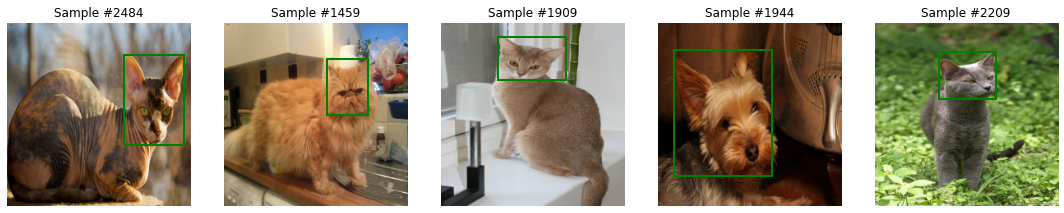

In [ ]:
count_imgs = 5 # задаем количество выводимых изображений

indices = list(range(len(data_v)))
np.random.shuffle(indices) # задаем случайный выбор изображений
count = 0
plt.figure(figsize=(15,15))
for i in indices:
    sample = data_v[i]      
    if sample['label'] == 0: label = 'cat'
    else: label = 'dog'      
    print('№', i, '  image shape:', sample['image'].shape, '  label:', label, '  bb coords:', sample['bb_coords'])   
    ax = plt.subplot(1, count_imgs, count + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    draw_bb(sample['image'], sample['bb_coords']) # функция для рисования bounding box
    count += 1

    if count == count_imgs:
        plt.show()
        break

# Способ 1 - создаем собственную сеть 

##Тренировка

Создадим простую сеть с тремя сверточными слоями по 32, 64 и 128 нейронов и одним полносвязным слоем, который будет выдавать предсказания. Для лучшей сходимости добавим слои с нормализацией батчей входных изображений. 
Также в данной ячейке определим функции потерь, метод оптимизации и метод корректировки коэффициента обучения. 

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
       
            nn.Flatten(),
            Linear2out(128*7*7, 2, 4) # модифицированный линейный слой с 2 выходами для классификации                       
          )                           # и 4 выходами для координат bounding box

nn_model.type(torch.cuda.FloatTensor) # задаем модель в cuda
nn_model.to(device) #загружаем модель на GPU

loss_class = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # определяем функцию потерь классификации
loss_reg = nn.MSELoss().type(torch.cuda.FloatTensor) # определяем функцию потерь регрессии
optimizer = optim.Adam(nn_model.parameters(), lr=1e-3, weight_decay=1e-2) # определяем метод оптимизации параметров сети
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.1, patience=5, threshold=0.01) # используем learning rate anneling на плато

Задаем количество эпох обучения. Вызываем функцию обучения train_model из модуля TrainValidTest. В результате будет сохранен файл .pth с лучшими параметрами сети при максимальном mioU, настроенными при обучении. 

In [ ]:
num_epochs = 30

path_save_model = '/content/drive/My Drive/ClassReg/best_models_save/' # путь к папке для сохранения лучшей модели

train_loss_history, train_accuracy_history, train_miou_history, val_loss_history, val_accuracy_history, val_miou_history = \
    tr.train_model(nn_model, train_loader, val_loader, loss_class, loss_reg, optimizer, num_epochs, 'best_my_model.pth', path_save_model, scheduler=scheduler)

Ep: 1 ==> Train loss: 4.531983, Val loss: 0.590450, Train accuracy: 0.6178, Val accuracy: 0.6946, Train miou: 0.1451, Val miou: 0.2731, lr: 1.0e-03, time: 0.26 ms
Ep: 2 ==> Train loss: 0.616894, Val loss: 0.583165, Train accuracy: 0.6911, Val accuracy: 0.6846, Train miou: 0.2611, Val miou: 0.2732, lr: 1.0e-03, time: 0.26 ms
Ep: 3 ==> Train loss: 0.577890, Val loss: 0.551003, Train accuracy: 0.7138, Val accuracy: 0.7215, Train miou: 0.2651, Val miou: 0.2833, lr: 1.0e-03, time: 0.26 ms
Ep: 4 ==> Train loss: 0.574798, Val loss: 0.543822, Train accuracy: 0.7183, Val accuracy: 0.7248, Train miou: 0.2732, Val miou: 0.2216, lr: 1.0e-03, time: 0.26 ms
Ep: 5 ==> Train loss: 0.518493, Val loss: 0.542881, Train accuracy: 0.7566, Val accuracy: 0.7248, Train miou: 0.2811, Val miou: 0.3108, lr: 1.0e-03, time: 0.26 ms
Ep: 6 ==> Train loss: 0.484102, Val loss: 0.569705, Train accuracy: 0.7797, Val accuracy: 0.7315, Train miou: 0.2846, Val miou: 0.2483, lr: 1.0e-03, time: 0.26 ms
Ep: 7 ==> Train loss: 

Выводим графики зависимости функции потерь, точности и miou на тренировочных данных (голубая кривая) и валидационных данных (оранжевая кривая) от эпохи обучения.

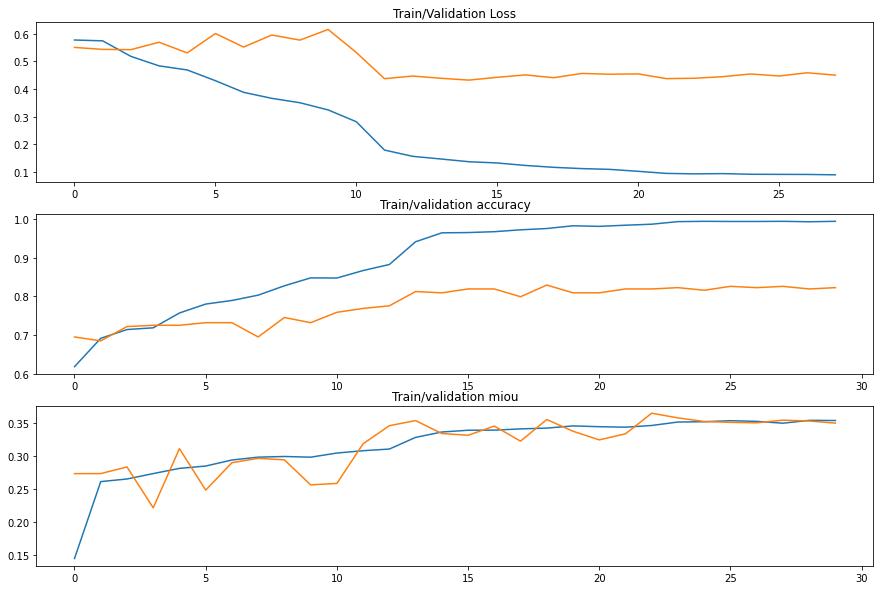

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.title("Train/Validation Loss")
plt.plot(train_loss_history[2:])
plt.plot(val_loss_history[2:])
plt.subplot(312)
plt.title("Train/validation accuracy")
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.subplot(313)
plt.title("Train/validation miou")
plt.plot(train_miou_history)
plt.plot(val_miou_history)

## Испытаем обученную модель на тестовых данных

Определяем архитектуру обученной модели. 

In [ ]:
nn_model = nn.Sequential(
            nn.Conv2d(3, 32, 7, padding=3),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(32, 64, 5, padding=2),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(4),

            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2),
       
            nn.Flatten(),
            Linear2out(128*7*7, 2, 4)                     
          )

Загружаем параметры обученной модели.

In [ ]:
load_model = nn_model
load_model.load_state_dict(torch.load('/content/drive/My Drive/ClassReg/best_models_save/best_my_model.pth')) 
load_model.to(device)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
  (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU(inplace=True)
  (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Flatten(start_dim=1, end_dim=-1)
  (13): Linear2out(
    (LinearClass): Linear(in_features=6272, out_features=2, bias=True)
    (LinearIn): Linear(in_features=6272, out_feat

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора и нормализацию (по вычисленным заранее значениям среднего и стандартного отклонения). Создаем тестовый датасет и стандартный загрузчик PyTorch.

In [ ]:
tfms = transforms.Compose([ds.Resize((224,224)), ds.ToTensor(), ds.Normalize()])
data_test = ds.CustomDataset('/content/cats_dogs_dataset/valid/', transform=tfms)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=1, num_workers=1)

Проверяем обученную модель на тестовых данных используя функцию test_model из модуля TrainValidTest. В результате будет выведена точность классификации изображений и метрика локализации bounding box.  

In [ ]:
test_accuracy, test_miou, test_labels, test_bb_coords, test_iou_all = tr.test_model(load_model, test_loader)

print('Test accuracy = %4f, Test miou = %4f' % (test_accuracy, test_miou))

Test accuracy = 0.802500, Test miou = 0.328498


Зададим трансформацию разрешения изображений и создадим датасет для визулизации некоторых изображений.

In [ ]:
tfms_v_t = transforms.Compose([ds.Resize_Visual((224,224))])
data_v_t = ds.CustomDataset('/content/cats_dogs_dataset/valid/', transform=tfms_v_t)

Визуализируем некоторые картинки, с истинными и предсказанными метками классов и bounding boxes (зеленые - заданные, красные - предсказанные).

№ 90   label: cat   predict label: cat   iou: 0.57970417
№ 288   label: cat   predict label: cat   iou: 0.58247554
№ 19   label: dog   predict label: dog   iou: 0.59683096
№ 249   label: dog   predict label: dog   iou: 0.6316991
№ 254   label: dog   predict label: dog   iou: 0.51540494


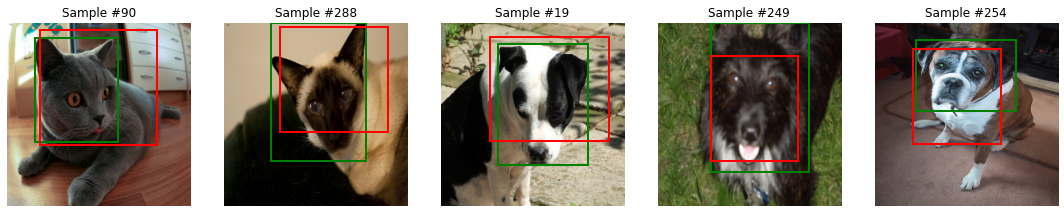

In [ ]:
count_imgs = 5 # количество выводимых изображений
threshold = 0.5 # уровень качества предсказанной метрики iou (больше, либо равен)

indices = list(range(len(test_bb_coords)))
np.random.shuffle(indices)
count = 0
plt.figure(figsize=(15,15))
for i in indices:
    if test_iou_all[i] >= threshold: 
        sample = data_v_t[i]

        if sample['label'] == 0: label = 'cat'
        else: label = 'dog'
        if test_labels[i] == 0: pr_label = 'cat'
        else: pr_label = 'dog'  
        # выведем истинные и предсказанные метки изображения и метрику iou
        print('№', i, '  label:', label, '  predict label:', pr_label, '  iou:', test_iou_all[i].cpu().numpy())        

        ax = plt.subplot(1, count_imgs, count + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')              
        draw_bb(sample['image'], sample['bb_coords'], testing=False) # рисуем истинный bounding box

        t_c = copy.deepcopy(test_bb_coords[i])
        hw = sample['param_img']
        t_c[0::2] = t_c[0::2] * hw[1] # переводим относительные координаты bounding box к пиксельному
        t_c[1::2] = t_c[1::2] * hw[0] # представлению используя сохраненные размеры исходного изображения
        t_c = t_c.astype(int)
        draw_bb(sample['image'], t_c, testing=True) # рисуем предсказанный bounding box
        count += 1 

    if count == count_imgs: break      

# Способ 2 - transfer learning

##Тренировка

Попробуем для классификации использовать предобученную модель, например resnet18. Она обучена на датасете ImageNet.
Сначала попробуем заменить последний слой на новый и обучить только его, при этом, заморозив все остальные. 

In [ ]:
model = models.resnet18(pretrained=True) # загружаем натренированную модель

for param in model.parameters(): # замораживаем слои
    param.requires_grad = False
num_ftrs = model.fc.in_features

model.fc = Linear2out(num_ftrs, 2, 4) # заменяем последний слой
model = model.to(device)

num_epochs = 20 # задаем количество эпох обучения

loss_class = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # определяем функцию потерь классификации
loss_reg = nn.MSELoss().type(torch.cuda.FloatTensor) # определяем функцию потерь регрессии
optimizer = optim.Adam(model.fc.parameters(), lr=1e-2) # определяем метод оптимизации параметров сети
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=3, threshold=0.03) # используем learning rate anneling на плато

path_save_model = '/content/drive/My Drive/ClassReg/best_models_save/' # путь к папке для сохранения лучшей модели

train_loss_history, train_accuracy_history, train_miou_history, val_loss_history, val_accuracy_history, val_miou_history = \
    tr.train_model(model, train_loader, val_loader, loss_class, loss_reg, optimizer, num_epochs, 'best_resnet18_freeze.pth', path_save_model, scheduler=scheduler)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Ep: 1 ==> Train loss: 7.992192, Val loss: 0.072289, Train accuracy: 0.9278, Val accuracy: 0.9832, Train miou: 0.1285, Val miou: 0.2748, lr: 1.0e-02, time: 1.16 ms
Ep: 2 ==> Train loss: 0.077858, Val loss: 0.058785, Train accuracy: 0.9732, Val accuracy: 0.9799, Train miou: 0.2902, Val miou: 0.3162, lr: 1.0e-02, time: 1.16 ms
Ep: 3 ==> Train loss: 0.076242, Val loss: 0.105212, Train accuracy: 0.9743, Val accuracy: 0.9765, Train miou: 0.3032, Val miou: 0.2738, lr: 1.0e-02, time: 1.16 ms
Ep: 4 ==> Train loss: 0.058621, Val loss: 0.060500, Train accuracy: 0.9833, Val accuracy: 0.9899, Train miou: 0.3068, Val miou: 0.3332, lr: 1.0e-02, time: 1.16 ms
Ep: 5 ==> Train loss: 0.037585, Val loss: 0.042920, Train accuracy: 0.9892, Val accuracy: 0.9866, Train miou: 0.3159, Val miou: 0.3116, lr: 1.0e-02, time: 1.17 ms
Ep: 6 ==> Train loss: 0.047409, Val loss: 0.041727, Train accuracy: 0.9877, Val accuracy: 0.9866, Train miou: 0.3302, Val miou: 0.3541, lr: 1.0e-02, time: 1.20 ms
Ep: 7 ==> Train loss:

Как мы видим, нам не удалось преодолеть miou на валидации выше 36,5%. 
Попробуем другой вариант, также заменим последний слой, но при этом будем тренировать всю модель.

In [ ]:
model = models.resnet18(pretrained=True)

num_ftrs = model.fc.in_features
model.fc = Linear2out(num_ftrs, 2, 4) # заменяем последний слой
model = model.to(device)

num_epochs = 30 # задаем количество эпох обучения

loss_class = nn.CrossEntropyLoss().type(torch.cuda.FloatTensor) # определяем функцию потерь классификации
loss_reg = nn.MSELoss().type(torch.cuda.FloatTensor) # определяем функцию потерь регрессии
optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-2) # определяем метод оптимизации параметров сети 
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=0.1, patience=5, threshold=0.001) # используем learning rate anneling на плато

path_save_model = '/content/drive/My Drive/ClassReg/best_models_save/' # путь к папке для сохранения лучшей модели

train_loss_history, train_accuracy_history, train_miou_history, val_loss_history, val_accuracy_history, val_miou_history = \
    tr.train_model(model, train_loader, val_loader, loss_class, loss_reg, optimizer, num_epochs, 'best_resnet18.pth', path_save_model, scheduler=scheduler)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth



Ep: 1 ==> Train loss: 0.163826, Val loss: 0.055098, Train accuracy: 0.9431, Val accuracy: 0.9866, Train miou: 0.1767, Val miou: 0.2324, lr: 1.0e-04, time: 1.11 ms
Ep: 2 ==> Train loss: 0.029328, Val loss: 0.032653, Train accuracy: 0.9959, Val accuracy: 0.9966, Train miou: 0.3021, Val miou: 0.3028, lr: 1.0e-04, time: 1.09 ms
Ep: 3 ==> Train loss: 0.013496, Val loss: 0.032299, Train accuracy: 0.9996, Val accuracy: 0.9966, Train miou: 0.3527, Val miou: 0.3240, lr: 1.0e-04, time: 1.09 ms
Ep: 4 ==> Train loss: 0.008186, Val loss: 0.025380, Train accuracy: 1.0000, Val accuracy: 0.9966, Train miou: 0.3987, Val miou: 0.3143, lr: 1.0e-04, time: 1.09 ms
Ep: 5 ==> Train loss: 0.006898, Val loss: 0.025709, Train accuracy: 1.0000, Val accuracy: 0.9966, Train miou: 0.4297, Val miou: 0.3783, lr: 1.0e-04, time: 1.09 ms
Ep: 6 ==> Train loss: 0.005795, Val loss: 0.024637, Train accuracy: 1.0000, Val accuracy: 0.9966, Train miou: 0.4548, Val miou: 0.4021, lr: 1.0e-04, time: 1.10 ms
Ep: 7 ==> Train loss:

Выводим графики зависимости функции потерь, точности и miou на тренировочных данных (голубая кривая) и валидационных данных (оранжевая кривая) от эпохи обучения.

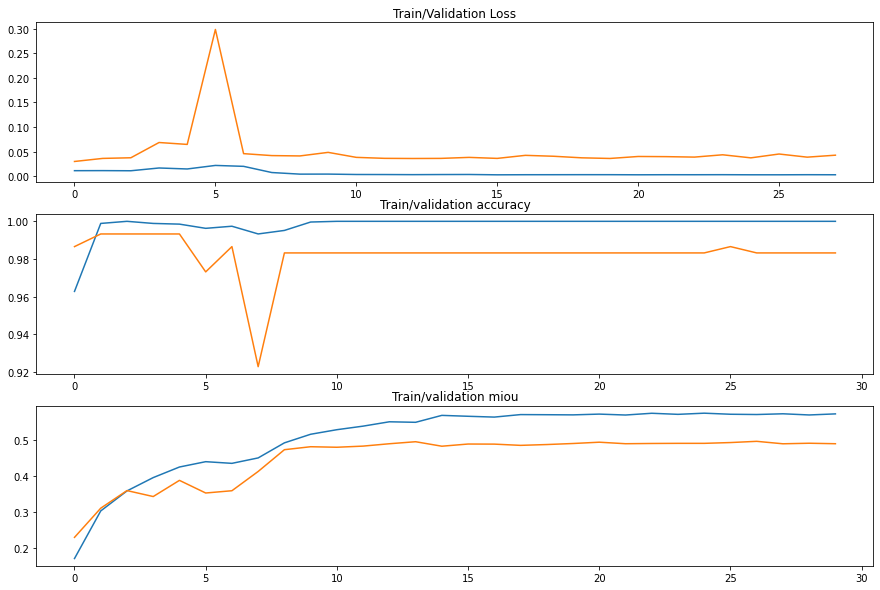

In [ ]:
plt.figure(figsize=(15, 10))
plt.subplot(311)
plt.title("Train/Validation Loss")
plt.plot(train_loss_history[2:])
plt.plot(val_loss_history[2:])
plt.subplot(312)
plt.title("Train/validation accuracy")
plt.plot(train_accuracy_history)
plt.plot(val_accuracy_history)
plt.subplot(313)
plt.title("Train/validation miou")
plt.plot(train_miou_history)
plt.plot(val_miou_history)

## Испытаем обученную модель на тестовых данных

Загружаем параметры обученной модели.

In [ ]:
load_model = models.resnet18(pretrained=True)

num_ftrs = load_model.fc.in_features
load_model.fc = Linear2out(num_ftrs, 2, 4)
load_model = load_model.to(device)

load_model.load_state_dict(torch.load('/content/drive/My Drive/ClassReg/best_models_save/best_resnet18.pth')) 
load_model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Задаем трансформацию для входных изображений, а именно: изменение размера, перевод в формат тензора и нормализацию (по вычисленным заранее значениям среднего и стандартного отклонения). Создаем тестовый датасет и стандартный загрузчик PyTorch.

In [ ]:
tfms = transforms.Compose([ds.Resize((224,224)), ds.ToTensor(), ds.Normalize()])
data_test = ds.CustomDataset('/content/cats_dogs_dataset/valid/', transform=tfms)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=1, num_workers=1)

Проверяем обученную модель на тестовых данных используя функцию test_model из модуля TrainValidTest. В результате будет выведена точность классификации изображений и метрика локализации bounding box.

In [ ]:
test_accuracy, test_miou, test_labels, test_bb_coords, test_iou_all = tr.test_model(load_model, test_loader)

print('Test accuracy = %4f, Test miou = %4f' % (test_accuracy, test_miou))

Test accuracy = 0.982500, Test miou = 0.560877


Зададим трансформацию разрешения изображений и создадим датасет для визулизации некоторых изображений.

In [ ]:
tfms_v_t = transforms.Compose([ds.Resize_Visual((224,224))])
data_v_t = ds.CustomDataset('/content/cats_dogs_dataset/valid/', transform=tfms_v_t)

Визуализируем некоторые картинки, с истинными и предсказанными метками классов и bounding boxes (зеленые - заданные, красные - предсказанные).

№ 363   label: cat   predict label: cat   iou: 0.58217907
№ 28   label: dog   predict label: dog   iou: 0.72748053
№ 187   label: dog   predict label: dog   iou: 0.74155045
№ 192   label: dog   predict label: dog   iou: 0.6794766
№ 327   label: dog   predict label: dog   iou: 0.59225


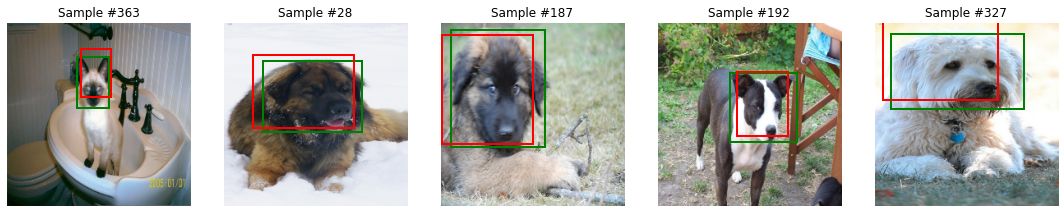

In [ ]:
count_imgs = 5 # количество выводимых изображений
threshold = 0.5 # уровень качества предсказанной метрики iou (больше, либо равен)

indices = list(range(len(test_bb_coords)))
np.random.shuffle(indices)
count = 0
plt.figure(figsize=(15,15))
for i in indices:
    if test_iou_all[i] >= threshold: 
        sample = data_v_t[i]

        if sample['label'] == 0: label = 'cat'
        else: label = 'dog'
        if test_labels[i] == 0: pr_label = 'cat'
        else: pr_label = 'dog'  
        # выведем истинные и предсказанные метки изображения и метрику iou
        print('№', i, '  label:', label, '  predict label:', pr_label, '  iou:', test_iou_all[i].cpu().numpy())        

        ax = plt.subplot(1, count_imgs, count + 1)
        plt.tight_layout()
        ax.set_title('Sample #{}'.format(i))
        ax.axis('off')              
        draw_bb(sample['image'], sample['bb_coords'], testing=False) # рисуем истинный bounding box

        t_c = copy.deepcopy(test_bb_coords[i])
        hw = sample['param_img']
        t_c[0::2] = t_c[0::2] * hw[1] # переводим относительные координаты bounding box к пиксельному
        t_c[1::2] = t_c[1::2] * hw[0] # представлению используя сохраненные размеры исходного изображения
        t_c = t_c.astype(int)
        draw_bb(sample['image'], t_c, testing=True) # рисуем предсказанный bounding box
        count += 1 

    if count == count_imgs: break  